In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
import sys

path = "C:/Users/schiavaz/lava-nc/depth/"
sys.path.append(path)

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import open3d as o3d
from tqdm import tqdm

import events_utils.filter as flt
import events_utils.visualize as vis
import events_utils.time_difference as td
import events_utils.time_difference_2d as td2d
import events_utils.tum_vie as tum_dset

from scipy.spatial.transform import Rotation as R

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
#define time range
t_start = 7.52
duration = 0.2
t_end = t_start + duration
shape_orig = (720, 1280)
dataset = "data/tum-vie-3d/"

In [4]:
events_raw = tum_dset.load_events_time(path + dataset + "mocap-3d-trans-events_right.h5", t_start, t_end)

C:\Users/schiavaz/lava-nc/depth\events_utils\tum_vie.py:38: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  events_h5 = h5py.File(f)["events"]
C:\Users/schiavaz/lava-nc/depth\events_utils\tum_vie.py:6: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  events_h5 = h5py.File(f)["events"]


6826126 events


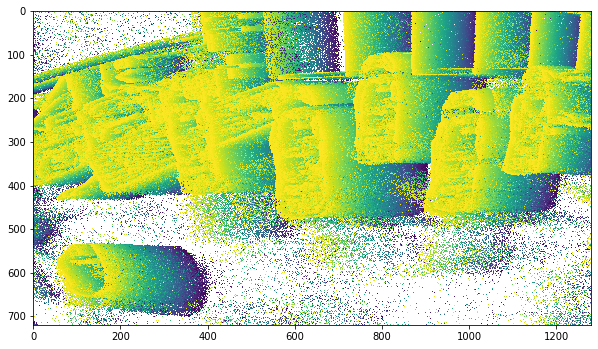

In [5]:
%matplotlib inline
plt.figure(figsize=(10, 10))
img = vis.events2time_surf(events_raw, shape_orig, filter_polarity=False, polarity=1)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m, interpolation="none")
#plt.colorbar(mappable=m)

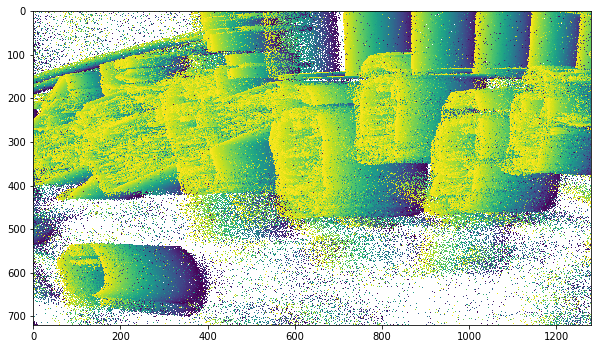

In [6]:
events_ref = flt.filter_refract(events_raw, 0.5)
%matplotlib inline
plt.figure(figsize=(10, 10))
img = vis.events2time_surf(events_ref, shape_orig, filter_polarity=False, polarity=1)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m, interpolation="none")
#plt.colorbar(mappable=m)

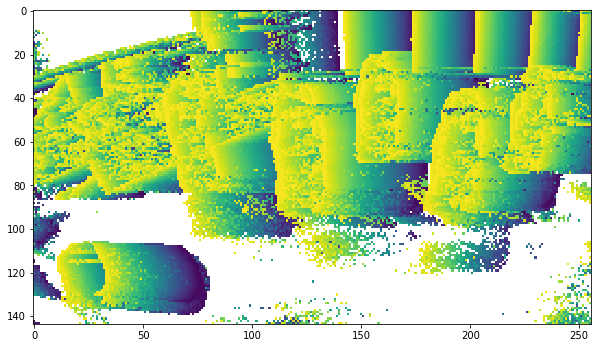

In [7]:
events, shape = flt.filter_conv(events_ref, shape_orig)
%matplotlib inline
plt.figure(figsize=(10, 10))
img = vis.events2time_surf(events, shape, filter_polarity=False, polarity=1)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m, interpolation="none")
#plt.colorbar(mappable=m)

In [8]:
# calib = np.loadtxt(path + dataset + "calib.txt")
focal_length = 1051.3170714099033

In [9]:
poses = tum_dset.load_poses(path + dataset + "mocap_data.txt")

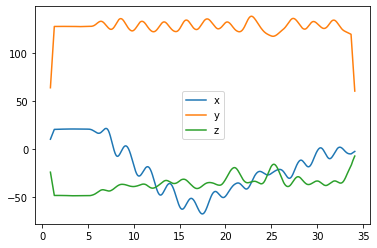

In [10]:
k = np.ones(100)
poses[:,1] = np.convolve(poses[:,1], k, mode="same")
poses[:,2] = np.convolve(poses[:,2], k, mode="same")
poses[:,3] = np.convolve(poses[:,3], k, mode="same")
poses[:,4] = np.convolve(poses[:,4], k, mode="same")
poses[:,5] = np.convolve(poses[:,5], k, mode="same")
poses[:,6] = np.convolve(poses[:,6], k, mode="same")
poses[:,7] = np.convolve(poses[:,7], k, mode="same")

plt.plot(poses[:,0], poses[:,1], label="x")
plt.plot(poses[:,0], poses[:,2], label="y")
plt.plot(poses[:,0], poses[:,3], label="z")
# plt.plot(poses[:,0], poses[:,4], label="q1")
# plt.plot(poses[:,0], poses[:,5], label="q2")
# plt.plot(poses[:,0], poses[:,6], label="q3")
# plt.plot(poses[:,0], poses[:,7], label="q4")
plt.legend()

In [11]:
def measure_td(events, shape, dist=1, start_delay=0.17):
    last_time = np.full(shape, -1.0)
    td_predictions = {}
    predictions = {}
    event_sign = np.full(shape, -1)

    U = np.zeros(shape)
    V = np.zeros(shape)

    start_time = events[0, 0]

    for e in tqdm(events):
        x = int(e[1])
        y = int(e[2])

        last_sign = event_sign[y, x]
        last_time[y, x] = e[0]
        event_sign[y, x] = e[3]

        if e[0] < start_time + start_delay:
            continue

        u_td = (e[0] - last_time[y - dist, x]
                if y - dist >= 0 and last_time[y - dist, x] != -1.0 and event_sign[y - dist, x] == e[3]
                else -1.0)
        d_td = (e[0] - last_time[y + dist, x]
                if y + dist < shape[0] and last_time[y + dist, x] != -1.0 and event_sign[y + dist, x] == e[3]
                else -1.0)
        r_td = (e[0] - last_time[y, x + dist]
                if x + dist < shape[1] and last_time[y, x + dist] != -1.0 and event_sign[y, x + dist] == e[3]
                else -1.0)
        l_td = (e[0] - last_time[y, x - dist]
                if x - dist >= 0 and last_time[y, x - dist] != -1.0 and event_sign[y, x - dist] == e[3]
                else -1.0)

        if u_td <= 0.0:
            if d_td <= 0.0:
                v_td = 0.0
                continue
            else:
                v_td = d_td
        else:
            if d_td > 0:
                #v_td = d_td if d_td >= u_td else -u_td
                v_td = 0.0
                continue
            else:
                v_td = -u_td

        if r_td <= 0.0:
            if l_td <= 0.0:
                h_td = 0.0
                continue
            else:
                h_td = l_td
        else:
            if l_td > 0:
                #h_td = l_td if l_td >= r_td else -r_td
                h_td = 0.0
                continue
            else:
                h_td = -r_td
                
        m = np.sqrt((1/h_td)**2 + (1/v_td)**2)
        if m > 300:
            continue
                
        U[y, x] = 1 / h_td# if h_td != 0.0 else 0.0
        V[y, x] = 1 / v_td #if v_td != 0.0 else 0.0
        
    return U, V

In [12]:
U, V = measure_td(events, shape, dist=2)

100%|██████████████████████████████████████████████████████████████████████| 135021/135021 [00:00<00:00, 271719.36it/s]


In [13]:
m = np.sqrt(U**2 + V**2)

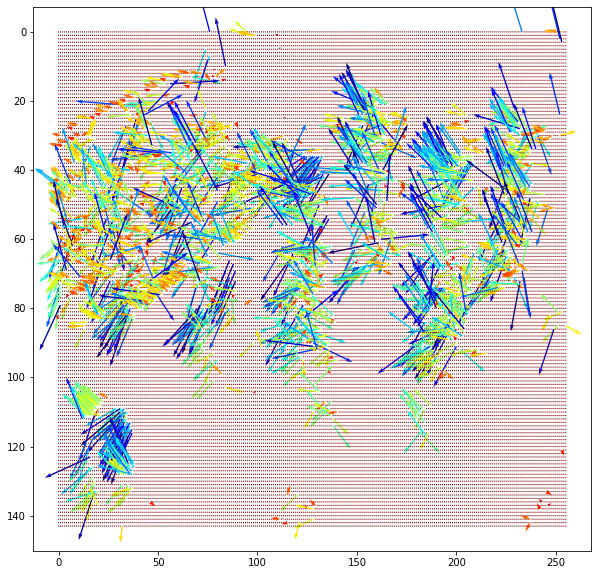

In [14]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(U, V, m, cmap="jet_r")
plt.gca().invert_yaxis()

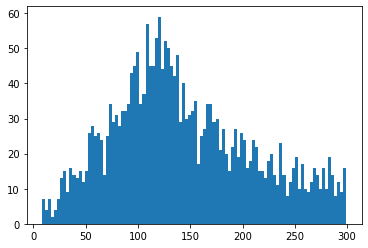

In [15]:
m_ma = np.ma.masked_where(np.isclose(m, 0.0), m)
plt.hist(m_ma.compressed(), 100);

In [16]:
time_d = td2d.TimeDifference2d(shape, events, poses, focal_length)
final_td, td_predictions, U, V, diff_list = time_d.compute_time_difference(dist = 2, px_range_pred=9, delay=0.18, avg_n=20, std_mul=0.01, debug=True, start_delay=0.05)
m = np.sqrt(U**2 + V**2)

(2, 3981)
[ 0.00129116  0.02514865 -0.16740636]


100%|███████████████████████████████████████████████████████████████████████| 135021/135021 [00:07<00:00, 17434.53it/s]

total: 135021
diff: 921
negative: 83372
q: 0
ang: 0
ind: 44491
img: 4933
filtered: 0


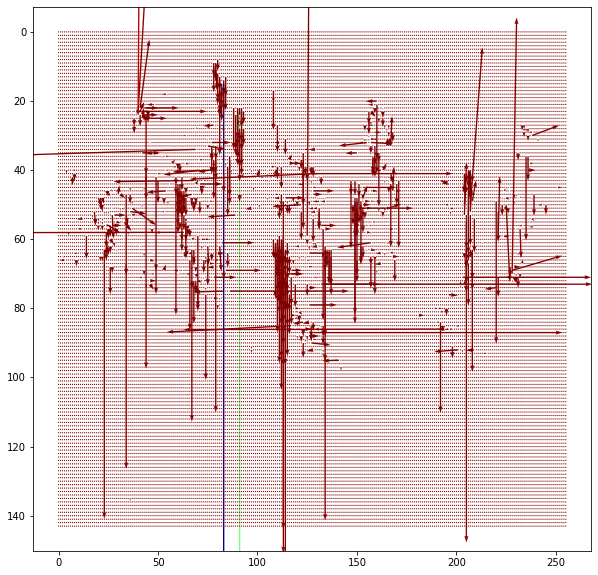

In [17]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(U, V, m, cmap="jet_r")
plt.gca().invert_yaxis()

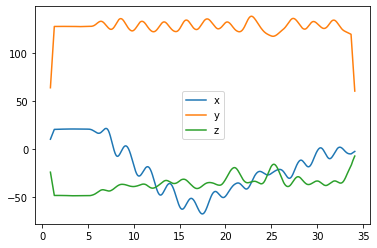

In [18]:
poses = tum_dset.load_poses(path + "data/tum-vie-3d/mocap_data.txt")
k = np.ones(100)
poses[:,1] = np.convolve(poses[:,1], k, mode="same")
poses[:,2] = np.convolve(poses[:,2], k, mode="same")
poses[:,3] = np.convolve(poses[:,3], k, mode="same")
poses[:,4] = np.convolve(poses[:,4], k, mode="same")
poses[:,5] = np.convolve(poses[:,5], k, mode="same")
poses[:,6] = np.convolve(poses[:,6], k, mode="same")
poses[:,7] = np.convolve(poses[:,7], k, mode="same")

plt.plot(poses[:,0], poses[:,1], label="x")
plt.plot(poses[:,0], poses[:,2], label="y")
plt.plot(poses[:,0], poses[:,3], label="z")
# plt.plot(poses[:,0], poses[:,4], label="q1")
# plt.plot(poses[:,0], poses[:,5], label="q2")
# plt.plot(poses[:,0], poses[:,6], label="q3")
# plt.plot(poses[:,0], poses[:,7], label="q4")
plt.legend()

In [19]:
idx = np.searchsorted(poses[:, 0], t_start)
pose1 = poses[idx]
pose2 = poses[idx + 1]

ang1 = R.from_quat(pose1[4:]).as_euler("xyz")
ang2 = R.from_quat(pose2[4:]).as_euler("xyz")

vel = (ang2 - ang1) / (pose2[0] - pose1[0])

print(vel)

[ 0.00065844  0.02368134 -0.16856209]


In [20]:
def get_angular_flow(w, f, shape):
    U_flow = np.zeros(shape)
    V_flow = np.zeros(shape)
    for x in range(U_flow.shape[1]):
        for y in range(U_flow.shape[0]):
            xi = x - 90
            yi = y - 90
            # if np.mod(x, 10) != 0 or np.mod(y, 10) != 0:
            #     continue
            m = np.array([
                [(xi * yi) / f, -(f + xi ** 2 / f), yi],
                [f + yi ** 2 / f, -xi * yi / f, -xi]
            ])
            r = m @ w
            U_flow[y, x] = r[0]
            V_flow[y, x] = r[1]
            
    return U_flow, V_flow

In [21]:
ang_U, ang_V = get_angular_flow(vel, focal_length, shape)

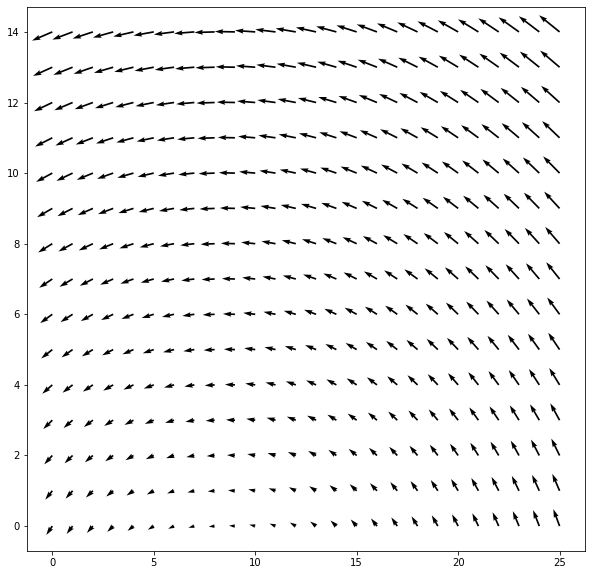

In [22]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(ang_U[::10, ::10], ang_V[::10, ::10], cmap="jet_r")
# plt.gca().invert_yaxis()

In [23]:
idx = np.searchsorted(poses[:, 0], t_start)
pose1 = poses[idx]
pose2 = poses[idx + 1]

t1 = pose1[1:4]
t2 = pose2[1:4]

print(t1)
print(t2)

t_vel = -(t2 - t1) #/ (pose2[0] - pose1[0])

print(t_vel)
print(pose2[0] - pose1[0])

[ 10.73716228 124.91954768 -43.40859607]
[ 10.4345246  124.92081463 -43.37010106]
[ 0.30263767 -0.00126696 -0.038495  ]
0.00833299999999948


In [24]:
def get_translational_flow(t, f, shape):
    U_flow = np.zeros(shape)
    V_flow = np.zeros(shape)
    for x in range(U_flow.shape[1]):
        for y in range(U_flow.shape[0]):
            xi = x - 90
            yi = y - 90
            # if np.mod(x, 10) != 0 or np.mod(y, 10) != 0:
            #     continue
            m = np.array([
                [-f, 0, xi],
                [0, -f, yi]
            ])
            r = m @ t
            U_flow[y, x] = r[0]
            V_flow[y, x] = r[1]
            
    return U_flow, V_flow

In [25]:
t_U, t_V = get_translational_flow(t_vel, focal_length, shape)

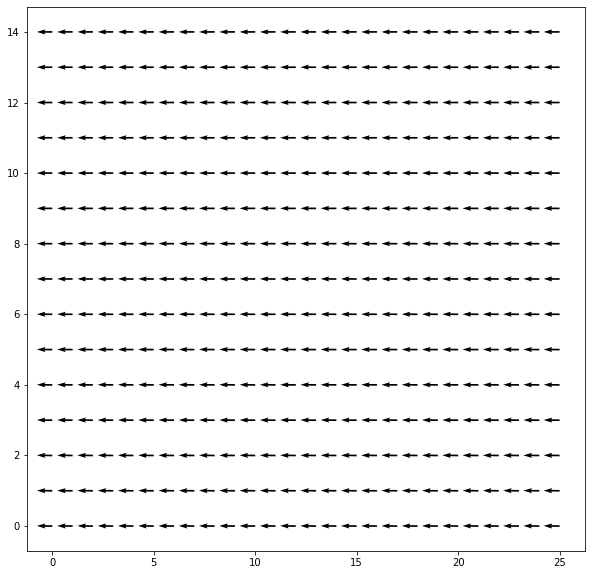

In [26]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(t_U[::10, ::10], t_V[::10, ::10], cmap="jet_r")
# plt.gca().invert_yaxis()

In [27]:
flow_U = t_U + ang_U
flow_V = t_V + ang_V

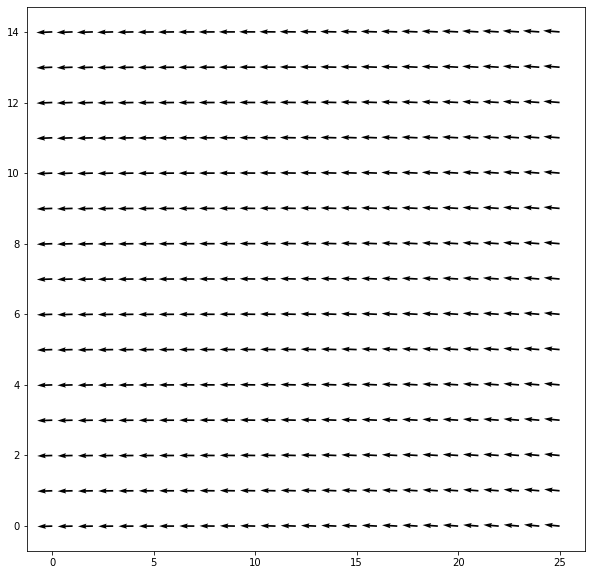

In [28]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(flow_U[::10, ::10], flow_V[::10, ::10], cmap="jet_r")
# plt.gca().invert_yaxis()

In [29]:
test_u = np.zeros(shape)
test_v = np.zeros(shape)
test = np.zeros(shape)
for x in range(U.shape[1]):
    for y in range(U.shape[0]):
        m = np.sqrt(np.square(U[y, x]) + np.square(V[y, x]))
        if m == 0.0:
            continue
        unit_n_u = U[y, x] / m
        unit_n_v = V[y, x] / m
        
        ang_p_u = ang_U[y, x] * unit_n_u
        ang_p_v = ang_V[y, x] * unit_n_v
        
        U_t = U[y, x] - ang_p_u
        V_t = V[y, x] - ang_p_v
        
        test_u[y, x] = U_t
        test_v[y, x] = V_t
        
        n = np.sqrt(t_U[y, x]**2 + t_V[y, x]**2)
        
        p = (U_t*t_U[y, x] + V_t*t_V[y, x]) / n
        
        u = t_U[y, x] * p
        v = t_V[y, x] * p
        
        test_u[y, x] = u
        test_v[y, x] = v
        
        a = t_U[y, x] / u if u != 0.0 else 0.0
        b = t_V[y, x] / v if v != 0.0 else 0.0
        
        d = a + b
        test[y, x] = d

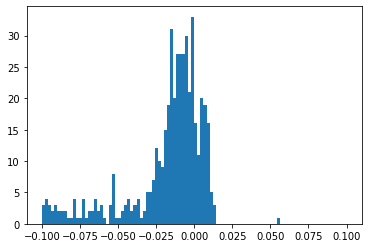

In [30]:
%matplotlib inline
test_m = np.ma.masked_where(np.isclose(test, 0.0), test)
plt.hist(test_m.compressed(), 100, range=(-0.1, 0.1));

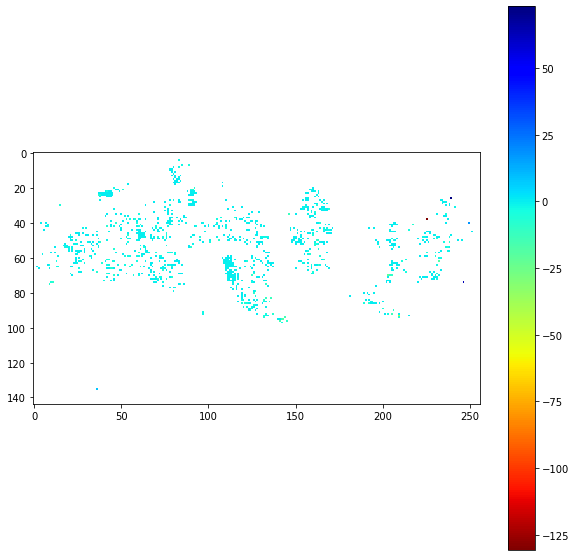

In [31]:
%matplotlib inline
plt.figure(figsize=(10, 10))
# img_gray = plt.imread(path + dataset + "images/frame_00000069.png")
# plt.imshow(img_gray, alpha=0.3, cmap="gray")
m = plt.imshow(test_m, interpolation="none", cmap="jet_r")
plt.colorbar(m)

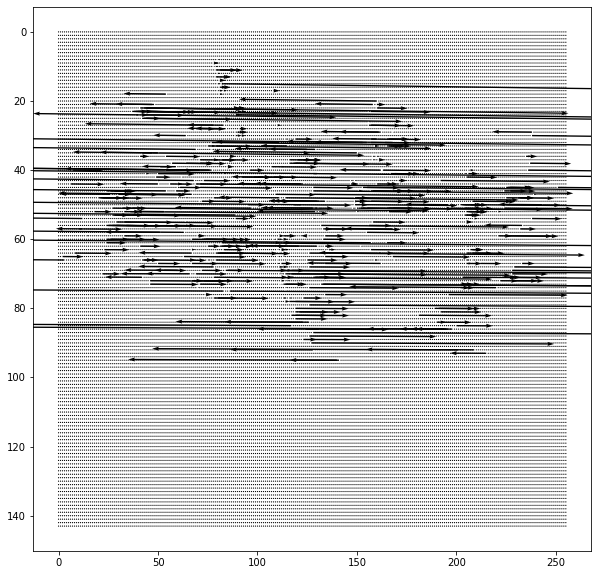

In [32]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(test_u[::1, ::1], test_v[::1, ::1], cmap="jet_r")
plt.gca().invert_yaxis()

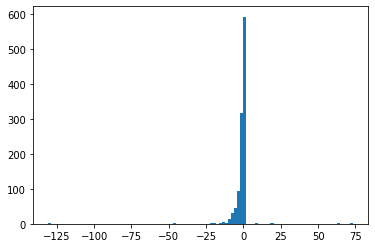

In [33]:
test_m = np.ma.masked_where(test == 0.0, test)
plt.hist(test_m.compressed(), 100);

In [34]:
%matplotlib qt
vis.visualize3d(test_m)